# Homework 2: Discovery of Frequent Itemsets and Association Rules
## Authors: Fabio Camerota, Gianluca Ruberto

## Solution
The goal of this project is to discover frequent itemsets with support at least s and to generate association rules with confidence at least c from the itemsets found in the previous step.

## Import libraries

In [1]:
from collections import defaultdict
from itertools import permutations 
from itertools import combinations
import os
import time
import matplotlib.pyplot as plt

## Load data
The dataset is the recommended one that is a sale transaction dataset where each line represents a transaction (basket) of hashed items.

In [2]:
datContent = [i.strip().split() for i in open("./dataset.dat").readlines()]

## Frequent itemsets
### Implementation of the A-Priori algorithm for finding frequent itemsets by exploiting the monotonicity of support (i.e. any subset of a frequent itemset must be frequent)

Filters the frequent itemsets so that only those with a support greater than s are considered (i.e. sets of items that appear in at least s baskets)

In [3]:
def filtered(tuple_dict,support):
    filteredDict = dict()
    for key in tuple_dict.keys():
        if tuple_dict[key] > support:
            filteredDict[key] = tuple_dict[key]
    return filteredDict

Generate all the singletons with the corresponding number of occurences

In [4]:
def generate_singletons():
    singletons = defaultdict(int) #if the item exists return the value, otherwise return 0
    for basket in datContent:
        for item in basket:
            value = singletons[item]
            value += 1
            singletons[item] = value
    return singletons

Generate all the couples with the corresponding number of occurences

In [5]:
def generate_couples(singletons_filtered):
    couples = defaultdict(int)
    singletons_set = set(singletons_filtered)
    for basket in datContent:
        basket_set = set(basket)
        intersection = basket_set.intersection(singletons_set)
        if (len(intersection) > 1):
            tuples = combinations(sorted(intersection), 2)
            for t in tuples:
                couples[t] += 1
    return couples

Generate all the k-tuples which is a dictionary, that has as keys triplets and as value the corresponding number of occurences

In [6]:
def generate_k_tuple(k_itemset):
    k_tuple = dict()
    for tup in k_itemset:
        for dat in datContent:
            if(set(tup)<=set(dat)):
                value = k_tuple.get(tup,0)
                value+=1
                k_tuple[tuple(tup)] = value
    return k_tuple

Create the k-itemset that are used in the generate_k_tuple() function, since itertools.combinations(k) cannot be used

In [7]:
def create_k_itemset(test,k):
    output = []
    final_output = []
    for i in range(0,len(test)):
        for j in range(i+1,len(test)):
           output.append(tuple(set(test[i]).union(set(test[j]))))
    for el in output:
        if(len(el)<=k): #remove itemsets greater than k
            final_output.append(el)
            comb = combinations(el, k)
            for el in comb:
                final_output.append(el)
    final_output = set(dict.fromkeys(sorted(final_output)))#remove duplicates
    return final_output

This function run all the above mentioned steps of the A-Priori algorithm

In [8]:
def generate_all_frequent_itemsets(support):
    all_frequent_itemsets = []
    singletons = generate_singletons()
    singletons_filtered = filtered(singletons,support)
    all_frequent_itemsets.append(singletons_filtered)
    couples = generate_couples(singletons_filtered)
    couples_filtered = filtered(couples,support)
    all_frequent_itemsets.append(couples_filtered)
    size_tuples = len(couples_filtered)
    k=3 #start from generating triples
    while(size_tuples>1):
        k_itemset = create_k_itemset(tuple(couples_filtered.keys()),k)
        k_tuple = generate_k_tuple(k_itemset)
        k_tuple_filtered = ordered_k_itemset(filtered(k_tuple,support))
        all_frequent_itemsets.append(k_tuple_filtered)
        size_tuples = len(k_tuple_filtered)
        k+=1
    return all_frequent_itemsets

## Association rules

Get the support of any k_tuple belonging to the set of all frequent_itemsets.
k_tuple is the key to access the dictionaries inside the frequent_itemsets list and get its number of occurrences.

In [9]:
def get_support(k_tuple, frequent_itemsets):
    if(len(k_tuple)==1):
        return frequent_itemsets[len(k_tuple)-1][k_tuple[0]]
    else:
        return frequent_itemsets[len(k_tuple)-1][tuple(sorted(k_tuple))]

To get the support of any k_tuple it's important to order their keys first, otherwise we get a key error

In [10]:
def ordered_k_itemset(itemset):
    output = dict()
    for el in itemset.keys():
        output[tuple(sorted(el))] = itemset[el]
    return output

Return the confidence of an association rule.
Confidence(I->J) = support(union(I,J)) / support(I)

In [11]:
def conf(k_tuple, arrow_position, frequent_itemsets):
    before_arrow = k_tuple[:arrow_position] #split the association to get only the left side
    union_support = get_support(k_tuple, frequent_itemsets)
    single_support = get_support(before_arrow, frequent_itemsets)
    return union_support / single_support

Generating association rules with confidence at least c from the itemsets found in the previous step

In [12]:
def generate_associations(confidence,all_frequent_itemsets):
    associations = set()
    for frequent_itemset in all_frequent_itemsets[1:]: #singletons are not used to generate associations, but they're used for getting support
        for k_tuple in frequent_itemset.keys():
            for tuple_permutation in permutations(k_tuple, len(k_tuple)):
                for arrow_position in range(1, len(tuple_permutation)):
                    c = conf(tuple_permutation, arrow_position, all_frequent_itemsets)
                    if c >= confidence:
                        associations.add((','.join(map(str, sorted(tuple_permutation[:arrow_position]))) + ' -> ' + ','.join(map(str, sorted(tuple_permutation[arrow_position:]))), c))
    return associations

# Computation

We obtained the following results, with support= 1% and confidence=0.8

In [13]:
support = int(len(datContent) * 0.01) #1% support , so >1000 occurrences
all_frequent_itemsets = generate_all_frequent_itemsets(support)
for index in range(0,len(all_frequent_itemsets)):
    print("We found "+str(len(all_frequent_itemsets[index]))+" frequent itemsets of length "+str(index+1))

We found 375 frequent itemsets of length 1
We found 9 frequent itemsets of length 2
We found 1 frequent itemsets of length 3


In [14]:
for index in range(0,len(all_frequent_itemsets)):
    print("These are the frequent itemsets of length "+str(index+1))
    print(all_frequent_itemsets[index])

These are the frequent itemsets of length 1
{'25': 1395, '52': 1983, '240': 1399, '274': 2628, '368': 7828, '448': 1370, '538': 3982, '561': 2783, '630': 1523, '687': 1762, '775': 3771, '825': 3085, '834': 1373, '39': 4258, '120': 4973, '205': 3605, '401': 3667, '581': 2943, '704': 1794, '814': 1672, '35': 1984, '674': 2527, '733': 1141, '854': 2847, '950': 1463, '422': 1255, '449': 1890, '857': 1588, '895': 3385, '937': 4681, '964': 1518, '229': 2281, '283': 4082, '294': 1445, '381': 2959, '708': 1090, '738': 2129, '766': 6265, '853': 1804, '883': 4902, '966': 3921, '978': 1141, '104': 1158, '143': 1417, '569': 2835, '620': 2100, '798': 3103, '185': 1529, '214': 1893, '350': 3069, '529': 7057, '658': 1881, '682': 4132, '782': 2767, '809': 2163, '947': 3690, '970': 2086, '227': 1818, '390': 2685, '71': 3507, '192': 2004, '208': 1483, '279': 3014, '280': 2108, '496': 1428, '530': 1263, '597': 2883, '618': 1337, '675': 2976, '720': 3864, '914': 4037, '932': 1786, '183': 3883, '217': 5375

In [15]:
confidence = 0.8
print("These are the associations computed from the above itemsets\n"+str(generate_associations(confidence,all_frequent_itemsets)))

These are the associations computed from the above itemsets
{('704,825 -> 39', 0.9392014519056261), ('39,825 -> 704', 0.8719460825610783), ('39,704 -> 825', 0.9349593495934959)}


Moreover, we carried out various experiments, changing the support and the confidence threshold. 
We measured the execution time, the number and size of the discovered frequent itemsets, and their association rules.

## Frequent itemsets experiments

In [16]:
one_percent = int(len(datContent) * 0.01)
two_percent = int(len(datContent) * 0.02)
five_percent = int(len(datContent) * 0.05)
supports = [one_percent, two_percent, five_percent]
durations = []
n_freq_items = []

for s in supports:
  start = time.time()
  freq_items = generate_all_frequent_itemsets(s)
  duration = time.time() - start
  print("By using support="+str(s)+" the execution time is "+str(duration))
  durations.append(duration)
  n_freq_items.append(freq_items)

By using support=1000 the execution time is 2.190770387649536
By using support=2000 the execution time is 0.7550277709960938
By using support=5000 the execution time is 0.24324417114257812


When we increase the support threshold, the execution time decreases, because less frequent itemsets are generated.

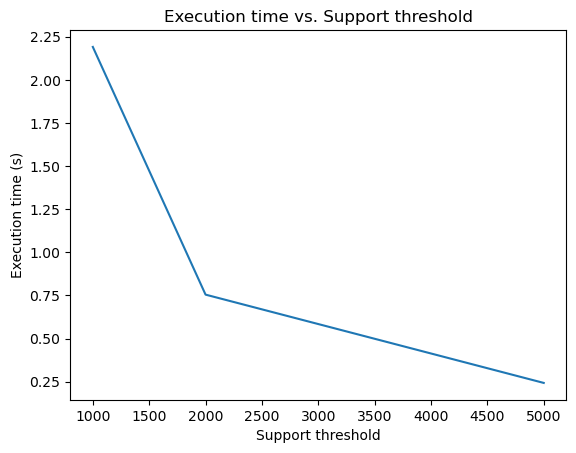

In [17]:
plt.plot(supports, durations)
plt.xlabel('Support threshold')
plt.ylabel('Execution time (s)')
plt.title('Execution time vs. Support threshold')
plt.show()

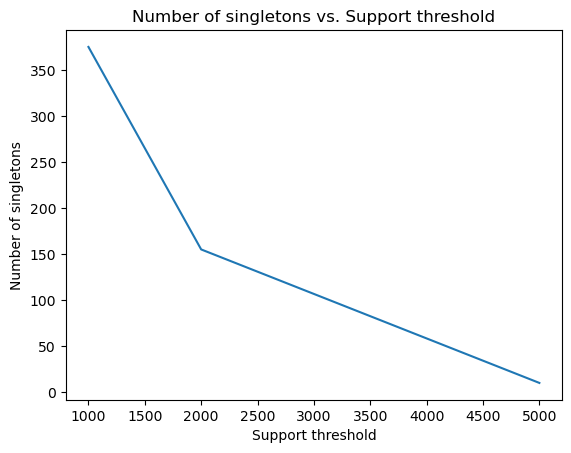

In [18]:
n_singletons = [0]* len(supports)
for i in range(len(n_singletons)):
    n_singletons[i]= len(n_freq_items[i][0])
plt.plot(supports, n_singletons)
plt.xlabel('Support threshold')
plt.ylabel('Number of singletons')
plt.title('Number of singletons vs. Support threshold')
plt.show()

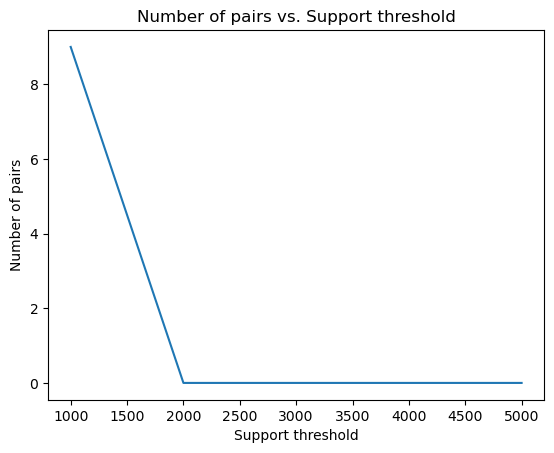

In [19]:
n_pairs = [0]* len(supports)
for i in range(len(n_pairs)):
    n_pairs[i]= len(n_freq_items[i][1])
plt.plot(supports, n_pairs)
plt.xlabel('Support threshold')
plt.ylabel('Number of pairs')
plt.title('Number of pairs vs. Support threshold')
plt.show()

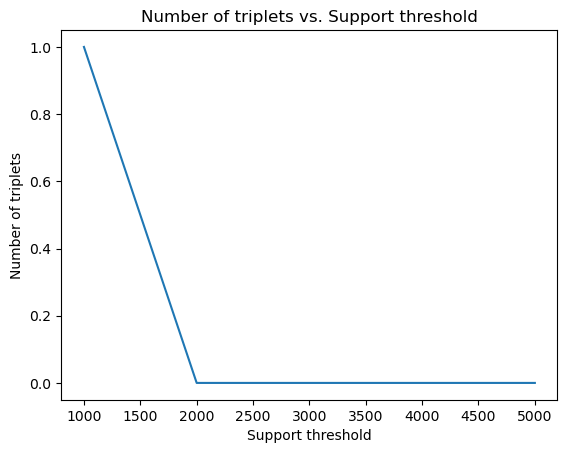

In [20]:
n_triplets= [0]* len(supports)
for i in range(len(n_triplets)):
    try:
        n_triplets[i]= len(n_freq_items[i][2])
    except:
        continue
plt.plot(supports, n_triplets)
plt.xlabel('Support threshold')
plt.ylabel('Number of triplets')
plt.title('Number of triplets vs. Support threshold')
plt.show()

## Association rules experiments

In [21]:
confidences = [0.01, 0.3, 0.5, 0.8]
durations = []
freq_items = generate_all_frequent_itemsets(1000)#support = 1000
number_rules = []
for c in confidences:
  start = time.time()
  associations = generate_associations(c,freq_items)
  duration = time.time() - start
  print("By using confidence="+str(c)+" the execution time is "+str(duration))
  durations.append(duration)
  number_rules.append(len(associations))

By using confidence=0.01 the execution time is 0.0001437664031982422
By using confidence=0.3 the execution time is 9.918212890625e-05
By using confidence=0.5 the execution time is 7.891654968261719e-05
By using confidence=0.8 the execution time is 6.699562072753906e-05


The execution time of this task is really low and it decreases as we increase the confidence threshold.

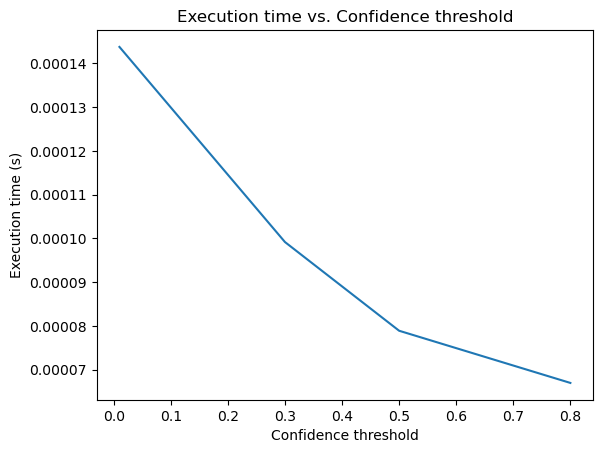

In [22]:
plt.plot(confidences, durations)
plt.xlabel('Confidence threshold')
plt.ylabel('Execution time (s)')
plt.title('Execution time vs. Confidence threshold')
plt.show()

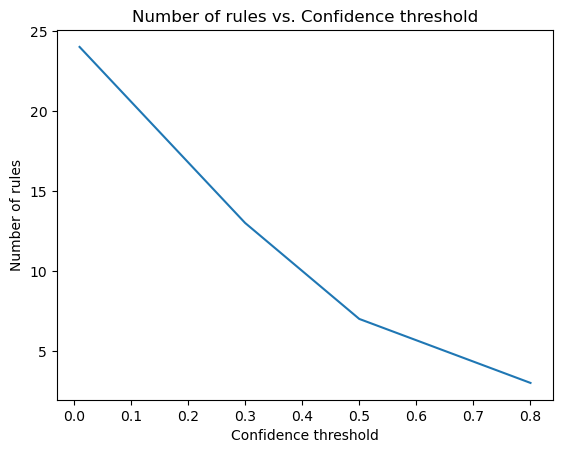

In [23]:
plt.plot(confidences, number_rules)
plt.xlabel('Confidence threshold')
plt.ylabel('Number of rules')
plt.title('Number of rules vs. Confidence threshold')
plt.show()